{/* cspell:ignore edgecolor */}

# Transpilation Optimizations with SABRE
*Usage estimate: under 1 minute on IBM Sherbrooke (NOTE: This is an estimate only. Your runtime may vary.)*

## Background
Transpilation is a critical step in Qiskit that converts quantum circuits into forms compatible with specific quantum hardware. It involves two key stages: **qubit layout** (mapping logical qubits to physical qubits on the device) and **gate routing** (ensuring multi-qubit gates respect device connectivity by inserting SWAP gates as needed).

SABRE (*SWAP-Based Bidirectional heuristic search algorithm*) is a powerful optimization tool for both layout and routing. It is especially effective for **large-scale circuits** (100+ qubits) and devices with complex coupling maps, like the **IBM Heron**, where the exponential growth in possible qubit mappings demands efficient solutions.

### Why use SABRE?

SABRE minimizes the number of SWAP gates and reduces circuit depth, improving circuit performance on real hardware. Its heuristic-based approach makes it ideal for advanced hardware and large, complex circuits. Recent improvements introduced in the [LightSABRE](https://arxiv.org/abs/2409.08368) algorithm further optimize SABRE’s performance, offering faster runtimes and fewer SWAP gates. These enhancements make it even more effective for large-scale circuits.

### What you’ll learn

This tutorial is divided into two parts:
1. Learn to use SABRE with **Qiskit Patterns** for advanced optimization of large circuits.
2. Leverage **qiskit_serverless** to maximize SABRE’s potential for scalable and efficient transpilation.

You will:
- Optimize SABRE for circuits with 100+ qubits, surpassing default transpilation settings like `optimization_level=3`.
- Explore **LightSABRE enhancements** that improve runtime and reduce gate counts.
- Customize key SABRE parameters (`swap_trials`, `layout_trials`, `max_iterations`, `heuristic`) to balance **circuit quality** and **transpilation runtime**.

## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.28 or later (`pip install qiskit-ibm-runtime`)
- Rustworkx graph library (`pip install rustworkx`)
- Serverless (`pip install qiskit-ibm-catalog qiskit_serverless`)

## Setup

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_catalog import QiskitServerless, QiskitFunction
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes import SabreLayout, SabreSwap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import matplotlib.pyplot as plt
import numpy as np
import time

## Part I. Using SABRE with Qiskit Patterns

SABRE can be used in Qiskit to optimize quantum circuits by handling both the qubit layout and gate routing stages. In this section, we’ll guide you through the **minimal example** of using SABRE with Qiskit patterns, with the primary focus on step 2 of optimization.

To run SABRE, you need:
- A **DAG** (Directed Acyclic Graph) representation of your quantum circuit.
- The **coupling map** from the backend, which specifies how qubits are physically connected.
- The **SABRE pass**, which applies the algorithm to optimize the layout and routing.

For this part, we’ll focus on the **SabreLayout** pass. It performs both layout and routing trials, working to find the most efficient initial layout while minimizing the number of SWAP gates needed. Importantly, `SabreLayout`, just by itself, internally optimizes both the layout and routing by storing the solution that adds the least number of SWAP gates. Note that when using just **SabreLayout**, we cannot change the heuristic of SABRE, but we are able to customize the number of `layout_trials`.

### Step 1: Map classical inputs to a quantum problem

A **GHZ (Greenberger-Horne-Zeilinger)** circuit is a quantum circuit that prepares an entangled state where all qubits are either in the `|0...0⟩` or `|1...1⟩` state. The GHZ state for $n$ qubits is mathematically represented as:
$$ |\text{GHZ}\rangle = \frac{1}{\sqrt{2}} \left( |0\rangle^{\otimes n} + |1\rangle^{\otimes n} \right) $$

It is constructed by applying:
1. A Hadamard gate to the first qubit to create superposition.
2. A series of CNOT gates to entangle the remaining qubits with the first.

For this example, we intentionally construct a **star-topology GHZ circuit** instead of a linear-topology one. In the star topology, the first qubit acts as the "hub," and all other qubits are entangled directly with it using CNOT gates. This choice is deliberate because, while the **linear topology GHZ state** can theoretically be implemented in $ O(N) $ depth on a linear coupling map without any SWAP gates, SABRE would trivially find an optimal solution by mapping a 100-qubit GHZ circuit to a subgraph of the backend's heavy-hex coupling map.

The **star topology GHZ circuit** poses a significantly more challenging problem. Although it can still theoretically be executed in $ O(N) $ depth without SWAP gates, finding this solution requires identifying an optimal initial layout, which is much harder due to the non-linear connectivity of the circuit. This topology serves as a better test case for evaluating SABRE, as it demonstrates how configuration parameters impact layout and routing performance under more complex conditions.

![ghz_star_topology.png](/images/tutorials/transpilation-optimizations-with-sabre/ghz_star_topology.avif)

Notably:
- The **HighLevelSynthesis** tool can produce the optimal $ O(N) $ depth solution for the star topology GHZ circuit without introducing SWAP gates, like shown in the image above.
- Alternatively, the **StarPrerouting** pass can reduce the depth further by guiding SABRE's routing decisions, though it may still introduce some SWAP gates. However, StarPrerouting increases runtime and requires integration into the initial transpilation process.

For the purposes of this notebook, we exclude both HighLevelSynthesis and StarPrerouting to isolate and highlight the direct impact of SABRE configuration on runtime and circuit depth. By measuring the expectation value $ \langle Z_0 Z_i \rangle $ for each qubit pair, we analyze:
- How well SABRE reduces SWAP gates and circuit depth.
- The effect of these optimizations on the fidelity of the executed circuit, where deviations from $ \langle Z_0 Z_i \rangle = 1 $ indicate loss of entanglement.!

In [2]:
# set seed for reproducibility
seed = 42
num_qubits = 100

# Create GHZ circuit
qc = QuantumCircuit(num_qubits)
qc.h(0)
for i in range(1, num_qubits):
    qc.cx(0, i)

qc.measure_all()

Next, we will map the operators of interest to evaluate the behavior of the system. Specifically, we will use `ZZ` operators between qubits to examine how the entanglement degrades as the qubits become farther apart. This analysis is critical because inaccuracies in the expectation values  $\langle Z_0 Z_i \rangle$ for distant qubits can reveal the impact of noise and errors in the circuit execution. By studying these deviations, we gain insight into how well the circuit preserves entanglement under different SABRE configurations and how effectively SABRE minimizes the impact of hardware constraints.

In [3]:
# ZZII...II, ZIZI...II, ... , ZIII...IZ
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (num_qubits - 2 - i)
    for i in range(num_qubits - 1)
]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

### Step 2: Optimize problem for quantum hardware execution

In this step, we focus on optimizing the circuit layout for execution on a specific quantum hardware device with 127 qubits. This is the main focus of the notebook, as we perform **SABRE optimizations and transpilation** to achieve the best circuit performance. Using the `SabreLayout` pass, we determine an initial qubit mapping that minimizes the need for SWAP gates during routing. By passing the `coupling_map` of the target backend, `SabreLayout` adapts the layout to the device's connectivity constraints.

We will use `generate_preset_pass_manager` with `optimization_level=3` for the transpilation process and customize the `SabreLayout` pass with different configurations. The goal is to find a setup that produces a transpiled circuit with the **lowest size and/or depth**, demonstrating the impact of SABRE optimizations.

#### Why Are Circuit Size and Depth Important?

- **Lower size (gate count):** Reduces the number of operations, minimizing opportunities for errors to accumulate.
- **Lower depth:** Shortens the overall execution time, which is critical for avoiding decoherence and maintaining quantum state fidelity.

By optimizing these metrics, we improve the circuit’s reliability and execution accuracy on noisy quantum hardware.

Select the backend.

In [ ]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
print(f"Using backend: {backend}")

Using backend: <IBMBackend('ibm_sherbrooke')>


To evaluate the impact of different configurations on circuit optimization, we will create three pass managers, each with unique settings for the `SabreLayout` pass. These configurations enable us to analyze the trade-off between circuit quality and transpilation time.

#### Key parameters
- **`max_iterations`**: The number of forward-backward routing iterations to refine the layout and reduce routing costs.
- **`layout_trials`**: The number of random initial layouts tested, selecting the one that minimizes SWAP gates.
- **`swap_trials`**: The number of routing trials for each layout, refining gate placement for better routing.

Increasing `layout_trials` and `swap_trials` enables more thorough optimization but increases transpilation time.

#### Configurations in this notebook
1. **`pm_1`**: Default settings with `optimization_level=3`.
   - `max_iterations=4`
   - `layout_trials=20`
   - `swap_trials=20`

2. **`pm_2`**: Increases the number of trials for better exploration.
   - `max_iterations=4`
   - `layout_trials=200`
   - `swap_trials=200`

3. **`pm_3`**: Extends `pm_2` by increasing the number of iterations for further refinement.
   - `max_iterations=8`
   - `layout_trials=200`
   - `swap_trials=200`

By comparing the results of these configurations, we aim to determine which achieves the best balance between circuit quality (e.g., size and depth) and computational cost.

In [5]:
# Get the coupling map from the backend
cmap = CouplingMap(backend().configuration().coupling_map)

# Create the SabreLayout passes for the custom configurations
sl_2 = SabreLayout(
    coupling_map=cmap,
    seed=seed,
    max_iterations=4,
    layout_trials=200,
    swap_trials=200,
)
sl_3 = SabreLayout(
    coupling_map=cmap,
    seed=seed,
    max_iterations=8,
    layout_trials=200,
    swap_trials=200,
)

# Create the pass managers, need to first create then configure the SabreLayout passes
pm_1 = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=seed
)
pm_2 = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=seed
)
pm_3 = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=seed
)

Now we can configure the `SabreLayout` pass in the custom pass managers. To do this we know that for the default `generate_preset_pass_manager` on `optimization_level=3`, the `SabreLayout` pass is at index 2, as `SabreLayout` occurs after `SetLayout` and `VF2Laout` passes. We can access this pass and modify its parameters.

In [6]:
pm_2.layout.replace(index=2, passes=sl_2)
pm_3.layout.replace(index=2, passes=sl_3)

With each pass manager configured, we will now execute the transpilation process for each. To compare results, we will track key metrics, including the transpilation time, the depth of the circuit (measured as the two-qubit gate depth), and the total number of gates in the transpiled circuits

In [7]:
# Transpile the circuit with each pass manager and measure the time
t0 = time.time()
tqc_1 = pm_1.run(qc)
t1 = time.time() - t0
t0 = time.time()
tqc_2 = pm_2.run(qc)
t2 = time.time() - t0
t0 = time.time()
tqc_3 = pm_3.run(qc)
t3 = time.time() - t0

# Obtain the depths and the total number of gates (circuit size)
depth_1 = tqc_1.depth(lambda x: x.operation.num_qubits == 2)
depth_2 = tqc_2.depth(lambda x: x.operation.num_qubits == 2)
depth_3 = tqc_3.depth(lambda x: x.operation.num_qubits == 2)
size_1 = tqc_1.size()
size_2 = tqc_2.size()
size_3 = tqc_3.size()

# Transform the observables to match the backend's ISA
operators_list_1 = [op.apply_layout(tqc_1.layout) for op in operators]
operators_list_2 = [op.apply_layout(tqc_2.layout) for op in operators]
operators_list_3 = [op.apply_layout(tqc_3.layout) for op in operators]

# Compute improvements compared to pass manager 1 (default)
depth_improvement_2 = ((depth_1 - depth_2) / depth_1) * 100
depth_improvement_3 = ((depth_1 - depth_3) / depth_1) * 100
size_improvement_2 = ((size_1 - size_2) / size_1) * 100
size_improvement_3 = ((size_1 - size_3) / size_1) * 100
time_increase_2 = ((t2 - t1) / t1) * 100
time_increase_3 = ((t3 - t1) / t1) * 100

print(
    f"Pass manager 1 (4,20,20)  : Depth {depth_1}, Size {size_1}, Time {t1:.4f} s"
)
print(
    f"Pass manager 2 (4,200,200): Depth {depth_2}, Size {size_2}, Time {t2:.4f} s"
)
print(f"  - Depth improvement: {depth_improvement_2:.2f}%")
print(f"  - Size improvement: {size_improvement_2:.2f}%")
print(f"  - Time increase: {time_increase_2:.2f}%")
print(
    f"Pass manager 3 (8,200,200): Depth {depth_3}, Size {size_3}, Time {t3:.4f} s"
)
print(f"  - Depth improvement: {depth_improvement_3:.2f}%")
print(f"  - Size improvement: {size_improvement_3:.2f}%")
print(f"  - Time increase: {time_increase_3:.2f}%")

Pass manager 1 (4,20,20)  : Depth 382, Size 3119, Time 0.5739 s
Pass manager 2 (4,200,200): Depth 370, Size 2864, Time 1.8647 s
  - Depth improvement: 3.14%
  - Size improvement: 8.18%
  - Time increase: 224.94%
Pass manager 3 (8,200,200): Depth 327, Size 2618, Time 1.2319 s
  - Depth improvement: 14.40%
  - Size improvement: 16.06%
  - Time increase: 114.67%


The results demonstrate that increasing the number of trials (`layout_trials` and `swap_trials`) can significantly improve circuit quality by reducing both depth and size. However, this improvement often comes at the cost of increased runtime due to the additional computation required to explore more potential layouts and routing paths.

Increasing the `max_iterations` can further enhance optimization by refining the layout through more forward-backward routing cycles. In this case, increasing `max_iterations` resulted in the most significant reduction in circuit depth and size, even reducing runtime compared to `pm_2`, likely by streamlining subsequent optimization stages.  It’s important to note, however, that the effectiveness of increasing `max_iterations` can vary significantly depending on the circuit. While more iterations may yield better layout and routing choices, they provide no guarantees and depend heavily on the circuit’s structure and the complexity of the connectivity constraints

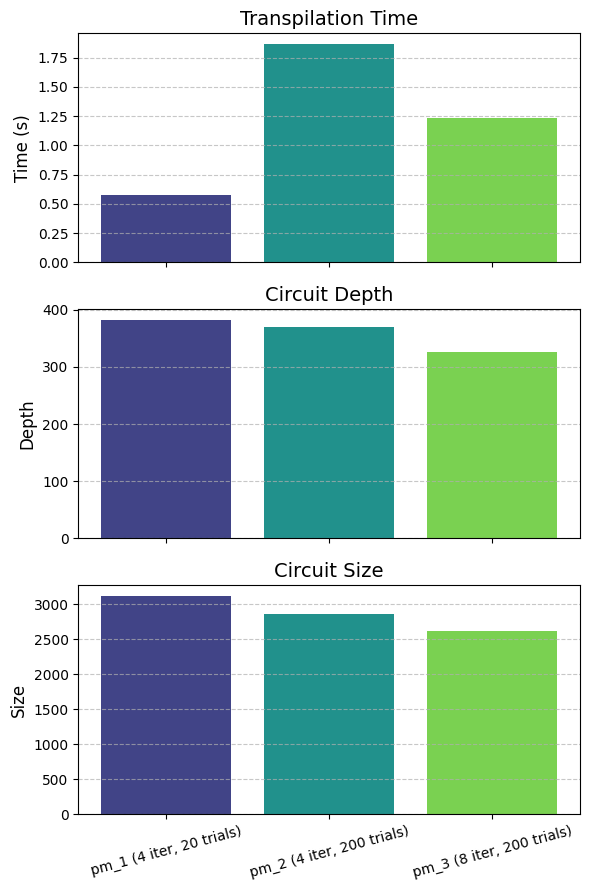

In [8]:
# Plot the results of the metrics
times = [t1, t2, t3]
depths = [depth_1, depth_2, depth_3]
sizes = [size_1, size_2, size_3]
pm_names = [
    "pm_1 (4 iter, 20 trials)",
    "pm_2 (4 iter, 200 trials)",
    "pm_3 (8 iter, 200 trials)",
]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(pm_names)))

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 9), sharex=True)
axs[0].bar(pm_names, times, color=colors)
axs[0].set_ylabel("Time (s)", fontsize=12)
axs[0].set_title("Transpilation Time", fontsize=14)
axs[0].grid(axis="y", linestyle="--", alpha=0.7)
axs[1].bar(pm_names, depths, color=colors)
axs[1].set_ylabel("Depth", fontsize=12)
axs[1].set_title("Circuit Depth", fontsize=14)
axs[1].grid(axis="y", linestyle="--", alpha=0.7)
axs[2].bar(pm_names, sizes, color=colors)
axs[2].set_ylabel("Size", fontsize=12)
axs[2].set_title("Circuit Size", fontsize=14)
axs[2].set_xticks(range(len(pm_names)))
axs[2].set_xticklabels(pm_names, fontsize=10, rotation=15)
axs[2].grid(axis="y", linestyle="--", alpha=0.7)

# Add some spacing between subplots
plt.tight_layout()
plt.show()

### Step 3: Execute using Qiskit primitives

In this step, we use the `Estimator` primitive to calculate the expectation values $\langle Z_0 Z_i \rangle$ for the `ZZ` operators, evaluating the entanglement and execution quality of the transpiled circuits. To align with typical user workflows, we submit the job for execution and apply error suppression using **dynamical decoupling**, a technique that mitigates decoherence by inserting gate sequences to preserve qubit states. Additionally, we specify a resilience level to counteract noise, with higher levels providing more accurate results at the cost of increased processing time. This approach allows us to assess the performance of each pass manager configuration under realistic execution conditions.

In [9]:
options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# Create an Estimator object
estimator = Estimator(backend, options=options)

In [10]:
# Submit the circuit to Estimator
job_1 = estimator.run([(tqc_1, operators_list_1)])
job_1_id = job_1.job_id()
print(job_1_id)

job_2 = estimator.run([(tqc_2, operators_list_2)])
job_2_id = job_2.job_id()
print(job_2_id)

job_3 = estimator.run([(tqc_3, operators_list_3)])
job_3_id = job_3.job_id()
print(job_3_id)

cx7rsyfbqkhg0088r41g
cx7rsyzrkac00089ay9g
cx7rszfztp30008fspm0


In [11]:
# Run the jobs
result_1 = job_1.result()[0]
print("Job 1 done")
result_2 = job_2.result()[0]
print("Job 2 done")
result_3 = job_3.result()[0]
print("Job 3 done")

Job 1 done
Job 2 done
Job 3 done


### Step 4: Post-process and return result in desired classical format

Once the job completes, we analyze the results by plotting the expectation values  $\langle Z_0 Z_i \rangle$ for each qubit. In an ideal simulation, all  $\langle Z_0 Z_i \rangle$ values should be 1, reflecting perfect entanglement across the qubits. However, due to noise and hardware constraints, the expectation values typically decrease as `i` increases, revealing how entanglement degrades over distance.

In this step, we compare the results from each pass manager configuration to the ideal simulation. By examining the deviation of $\langle Z_0 Z_i \rangle$ from 1 for each configuration, we can quantify how well each pass manager preserves entanglement and mitigates the effects of noise. This analysis allows us to directly assess the impact of the SABRE optimizations on execution fidelity, providing insights into which configuration achieves the best balance between optimization quality and execution performance.

The results will be visualized to highlight differences across pass managers, showcasing how improvements in layout and routing influence the final circuit execution on noisy quantum hardware.

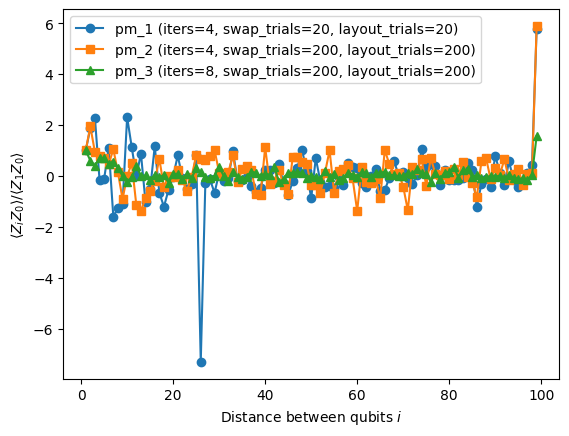

In [12]:
data = list(range(1, len(operators) + 1))  # Distance between the Z operators

# Normalize and process expectation values for each result
values_1 = [v / result_1.data.evs[0] for v in result_1.data.evs]
values_2 = [v / result_2.data.evs[0] for v in result_2.data.evs]
values_3 = [v / result_3.data.evs[0] for v in result_3.data.evs]

plt.plot(
    data,
    values_1,
    marker="o",
    label="pm_1 (iters=4, swap_trials=20, layout_trials=20)",
)
plt.plot(
    data,
    values_2,
    marker="s",
    label="pm_2 (iters=4, swap_trials=200, layout_trials=200)",
)
plt.plot(
    data,
    values_3,
    marker="^",
    label="pm_3 (iters=8, swap_trials=200, layout_trials=200)",
)
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()

### Analysis of Results

The plot shows how the normalized expectation values $\langle Z_0 Z_i \rangle$  vary across qubits for the three pass managers. Ideally, all values should remain close to 1, reflecting strong entanglement. However, noise and hardware errors introduce deviations, influenced by circuit size and depth.

With the largest circuit size and depth, `pm_1` exhibits significant variations in $\langle Z_0 Z_i \rangle$ , particularly for qubits farther apart, indicating poorer preservation of entanglement due to accumulated noise. In comparison, `pm_2` shows slightly improved results, with fewer deviations, reflecting its modest reductions in circuit size and depth (1–10% better than `pm_1`). These smaller improvements lead to slightly better fidelity but do not fully address the noise issues.

`pm_3`, with the most significant reductions in size and depth (11–20% better than `pm_1`), delivers the best results, with values much closer to 1 and fewer deviations. This highlights the critical role of minimizing circuit size and depth in reducing noise and error propagation, which significantly improves execution fidelity.

## Part II. Configuring the heuristic in SABRE and using Serverless

In addition to adjusting trial numbers, SABRE allows customization of the routing heuristic used during transpilation. By default, `SabreLayout` employs the decay heuristic, which dynamically weights qubits based on their likelihood of being swapped. To use a different heuristic (such as the `lookahead` heuristic), you can create a custom `SabreSwap` pass and connect it to `SabreLayout` by running a `PassManager` with `FullAncillaAllocation`, `EnlargeWithAncilla`, and `ApplyLayout`. When using `SabreSwap` as a parameter for `SabreLayout`, only one layout trial is performed by default. To efficiently run multiple layout trials, we leverage the serverless runtime for parallelization. For more about serverless, see the [Serverless documentation](https://docs.quantum.ibm.com/guides/serverless).

### How to Change the Routing Heuristic
1. Create a custom `SabreSwap` pass with the desired heuristic.
2. Use this custom `SabreSwap` as the routing method for the `SabreLayout` pass.

While it is possible to run multiple layout trials using a loop, serverless runtime is the better choice for large-scale and more vigorous experiments. Serverless allows for parallel execution of layout trials, significantly speeding up the process when optimizing larger circuits or conducting numerous experiments. This makes it especially valuable when working with resource-intensive tasks or when time efficiency is critical.

This section focuses solely on step 2 of optimization: minimizing circuit size and depth to achieve the best possible transpiled circuit. Building on the earlier results, we now explore how heuristic customization and serverless parallelization can further enhance optimization performance, making it suitable for large-scale quantum circuit transpilation.

### Results without serverless runtime (1 layout trial):

In [13]:
swap_trials = 200

# Default PassManager with `SabreLayout` and `SabreSwap`, using heuristic "decay"
sr_default = SabreSwap(
    coupling_map=cmap, heuristic="decay", trials=swap_trials, seed=seed
)
sl_default = SabreLayout(
    coupling_map=cmap, routing_pass=sr_default, seed=seed
)
pm_default = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=seed
)
pm_default.layout.replace(index=2, passes=sl_default)
pm_default.routing.replace(index=1, passes=sr_default)

t0 = time.time()
tqc_default = pm_default.run(qc)
t_default = time.time() - t0
size_default = tqc_default.size()
depth_default = tqc_default.depth(lambda x: x.operation.num_qubits == 2)


# Custom PassManager with `SabreLayout` and `SabreSwap`, using heuristic "lookahead"
sr_custom = SabreSwap(
    coupling_map=cmap, heuristic="lookahead", trials=swap_trials, seed=seed
)
sl_custom = SabreLayout(coupling_map=cmap, routing_pass=sr_custom, seed=seed)
pm_custom = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=seed
)
pm_custom.layout.replace(index=2, passes=sl_custom)
pm_custom.routing.replace(index=1, passes=sr_custom)

t0 = time.time()
tqc_custom = pm_custom.run(qc)
t_custom = time.time() - t0
size_custom = tqc_custom.size()
depth_custom = tqc_custom.depth(lambda x: x.operation.num_qubits == 2)

print(
    f"Default (heuristic='decay')    : Depth {depth_default}, Size {size_default}, Time {t_default}"
)
print(
    f"Custom  (heuristic='lookahead'): Depth {depth_custom}, Size {size_custom}, Time {t_custom}"
)

Default (heuristic='decay')    : Depth 395, Size 3552, Time 1.8260750770568848
Custom  (heuristic='lookahead'): Depth 389, Size 3384, Time 0.8961391448974609


Here we see that the `lookahead` heuristic performs better than the `decay` heuristic in terms of circuit depth, size, and time. This improvements highlights how we can improve SABRE beyond just trials and iterations for your specific circuit and hardware constraints. Note that these results are based on a single layout trial. To achieve more accurate results, we recommend running multiple layout trials, which can be done efficiently using the serverless runtime.

### Results with serverless runtime (multiple layout trials)

Qiskit Serverless requires setting up your workload’s `.py` files into a dedicated directory. The following code cell is a Python file in the `source_files` directory named `transpile_remote.py`. This file contains the function that runs the transpilation process.

In [ ]:
# This cell is hidden from users, it makes sure the `source_files` directory exists
from pathlib import Path

Path("source_files").mkdir(exists_ok=True)

In [ ]:
%%writefile source_files/transpile_remote.py
import time
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import SabreLayout, SabreSwap
from qiskit.transpiler import CouplingMap
from qiskit_serverless import get_arguments, save_result, distribute_task, get
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

@distribute_task(target={
    "cpu": 1,
    "mem": 1024 * 1024 * 1024
})
def transpile_remote(qc, optimization_level, backend, seed, swap_trials, heuristic):
    """Transpiles an abstract circuit into an ISA circuit for a given backend."""
    pm = generate_preset_pass_manager(
        optimization_level=optimization_level,
        backend=backend,
        seed_transpiler=seed
    )
    # Changing the `SabreLayout` and `SabreSwap` passes to use the custom configurations
    cmap = CouplingMap(backend().configuration().coupling_map)
    sr = SabreSwap(coupling_map=cmap, heuristic=heuristic, trials=swap_trials, seed=42)
    sl = SabreLayout(coupling_map=cmap, routing_pass=sr, seed=seed)
    pm.layout.replace(index=2, passes=sl)
    pm.routing.replace(index=1, passes=sr)

    # Measure the transpile time
    start_time = time.time()  # Start timer
    tqc = pm.run(qc)  # Transpile the circuit
    end_time = time.time()  # End timer

    transpile_time = end_time - start_time  # Calculate the elapsed time
    return tqc, transpile_time  # Return both the transpiled circuit and the transpile time

# Get program arguments
arguments = get_arguments()
circuit = arguments.get("circuit")
backend_name = arguments.get("backend_name")
optimization_level = arguments.get("optimization_level")
seed_list = arguments.get("seed_list")
swap_trials = arguments.get("swap_trials")
heuristic = arguments.get("heuristic")

# Get the backend
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.backend(backend_name)
print(backend)

# Transpile the circuits
transpile_worker_references = [
    transpile_remote(circuit, optimization_level, backend, seed, swap_trials, heuristic)
    for seed in arguments.get("seed_list")
]

results_with_times = get(transpile_worker_references)

# Separate the transpiled circuits and their transpile times
transpiled_circuits = [result[0] for result in results_with_times]
transpile_times = [result[1] for result in results_with_times]

# Save both results and transpile times
save_result({"transpiled_circuits": transpiled_circuits, "transpile_times": transpile_times})

The following cell uploads the `transpile_remote.py` file as a Qiskit Serverless program under the name `transpile_remote_serverless`.

In [14]:
serverless = QiskitServerless()

transpile_remote_demo = QiskitFunction(
    title="transpile_remote_serverless",
    entrypoint="transpile_remote.py",
    working_dir="./source_files/",
)
serverless.upload(transpile_remote_demo)
transpile_remote_serverless = serverless.load("transpile_remote_serverless")

Generate 20 different seeds to represent 20 different layout trials.

In [15]:
seed = 42
num_seeds = 200  # represents the different layout trials
seed_list = [seed + i for i in range(num_seeds)]

Run the uploaded program and pass inputs for lookahead heuristic.

In [16]:
job_lookahead = transpile_remote_serverless.run(
    circuit=qc,
    backend_name="ibm_brisbane",
    optimization_level=3,
    seed_list=seed_list,
    swap_trials=swap_trials,
    heuristic="lookahead",
)

In [17]:
job_lookahead.job_id

'f5475545-dd80-47fe-8a3d-3ef5d3f478fe'

In [18]:
job_lookahead.status()

'QUEUED'

Receive the logs and results from the serverless runtime.

In [19]:
logs_lookahead = job_lookahead.logs()
print(logs_lookahead)

No logs yet.


Once a program is `DONE`, you can use `job.results()` to fetch the result stored in `save_result()`.

In [20]:
# Run the job with lookahead heuristic
start_time = time.time()
results_lookahead = job_lookahead.result()
end_time = time.time()

job_lookahead_time = end_time - start_time

Now perform the same for decay heuristic.

In [21]:
job_decay = transpile_remote_serverless.run(
    circuit=qc,
    backend_name="ibm_brisbane",
    optimization_level=3,
    seed_list=seed_list,
    swap_trials=swap_trials,
    heuristic="decay",
)

In [22]:
job_decay.job_id

'084be271-68d0-49a3-a25d-3f5077e264ac'

In [23]:
logs_decay = job_decay.logs()
print(logs_decay)

No logs yet.


In [24]:
# Run the job with the decay heuristic
start_time = time.time()
results_decay = job_decay.result()
end_time = time.time()

job_decay_time = end_time - start_time

In [25]:
# Extract transpilation times
transpile_times_decay = results_decay["transpile_times"]
transpile_times_lookahead = results_lookahead["transpile_times"]

# Calculate total transpilation time for serial execution
total_transpile_time_decay = sum(transpile_times_decay)
total_transpile_time_lookahead = sum(transpile_times_lookahead)

# Print total transpilation time
print("=== Total Transpilation Time (Serial Execution) ===")
print(f"Decay Heuristic    : {total_transpile_time_decay:.2f} seconds")
print(f"Lookahead Heuristic: {total_transpile_time_lookahead:.2f} seconds")

# Print serverless job time (parallel execution)
print("\n=== Serverless Job Time (Parallel Execution) ===")
print(f"Decay Heuristic    : {job_decay_time:.2f} seconds")
print(f"Lookahead Heuristic: {job_lookahead_time:.2f} seconds")

# Calculate and print average runtime per transpilation
avg_transpile_time_decay = total_transpile_time_decay / num_seeds
avg_transpile_time_lookahead = total_transpile_time_lookahead / num_seeds
avg_job_time_decay = job_decay_time / num_seeds
avg_job_time_lookahead = job_lookahead_time / num_seeds

print("\n=== Average Time Per Transpilation ===")
print(f"Decay Heuristic (Serial)    : {avg_transpile_time_decay:.2f} seconds")
print(f"Decay Heuristic (Serverless): {avg_job_time_decay:.2f} seconds")
print(
    f"Lookahead Heuristic (Serial)    : {avg_transpile_time_lookahead:.2f} seconds"
)
print(
    f"Lookahead Heuristic (Serverless): {avg_job_time_lookahead:.2f} seconds"
)

# Calculate and print serverless improvement percentage
decay_improvement_percentage = (
    (total_transpile_time_decay - job_decay_time) / total_transpile_time_decay
) * 100
lookahead_improvement_percentage = (
    (total_transpile_time_lookahead - job_lookahead_time)
    / total_transpile_time_lookahead
) * 100

print("\n=== Serverless Improvement ===")
print(f"Decay Heuristic    : {decay_improvement_percentage:.2f}%")
print(f"Lookahead Heuristic: {lookahead_improvement_percentage:.2f}%")

=== Total Transpilation Time (Serial Execution) ===
Decay Heuristic    : 462.49 seconds
Lookahead Heuristic: 439.38 seconds

=== Serverless Job Time (Parallel Execution) ===
Decay Heuristic    : 172.37 seconds
Lookahead Heuristic: 159.30 seconds

=== Average Time Per Transpilation ===
Decay Heuristic (Serial)    : 2.31 seconds
Decay Heuristic (Serverless): 0.86 seconds
Lookahead Heuristic (Serial)    : 2.20 seconds
Lookahead Heuristic (Serverless): 0.80 seconds

=== Serverless Improvement ===
Decay Heuristic    : 62.73%
Lookahead Heuristic: 63.74%


These results demonstrate the significant efficiency of serverless execution in quantum circuit transpilation. For 200 layout trials, serverless reduced the runtime by over 60% for both the `decay` and `lookahead` heuristics compared to serial execution. The total transpilation time for `decay` (443.29 s) and `lookahead` (400.65 s) highlights the computational effort required for serial execution, while the serverless job times (157.97 s and 158.12 s, respectively) showcase the dramatic runtime reduction achieved through parallelization. These findings emphasize that serverless execution can effectively scale to larger problems, offering substantial time savings and enabling broader exploration of optimization trials with minimal overhead.

Obtain the results from the serverless runtime and compare the results of the lookahead and decay heuristics. We will compare the sizes and depths.

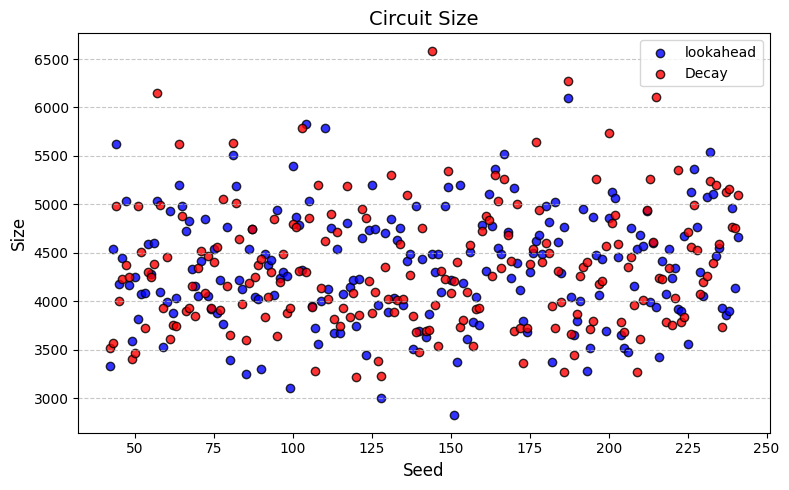

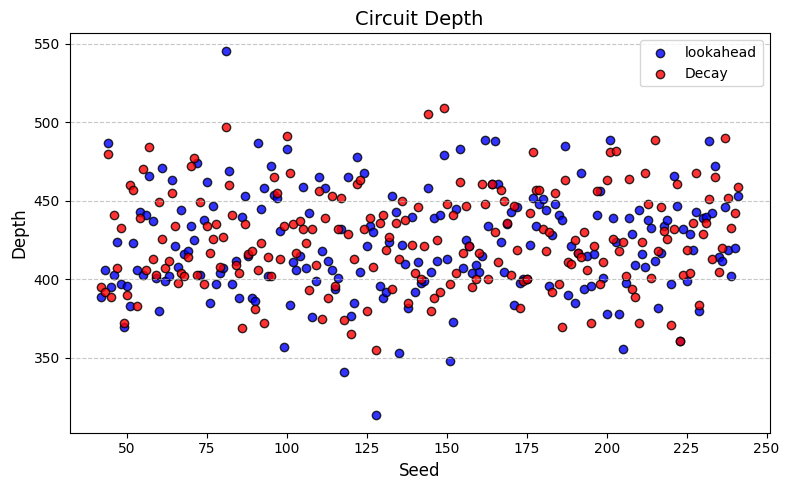

In [26]:
# Extract sizes and depths
sizes_lookahead = [
    circuit.size() for circuit in results_lookahead["transpiled_circuits"]
]
depths_lookahead = [
    circuit.depth(lambda x: x.operation.num_qubits == 2)
    for circuit in results_lookahead["transpiled_circuits"]
]
sizes_decay = [
    circuit.size() for circuit in results_decay["transpiled_circuits"]
]
depths_decay = [
    circuit.depth(lambda x: x.operation.num_qubits == 2)
    for circuit in results_decay["transpiled_circuits"]
]


def create_scatterplot(x, y1, y2, xlabel, ylabel, title, labels, colors):
    plt.figure(figsize=(8, 5))
    plt.scatter(
        x, y1, label=labels[0], color=colors[0], alpha=0.8, edgecolor="k"
    )
    plt.scatter(
        x, y2, label=labels[1], color=colors[1], alpha=0.8, edgecolor="k"
    )
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


create_scatterplot(
    seed_list,
    sizes_lookahead,
    sizes_decay,
    "Seed",
    "Size",
    "Circuit Size",
    ["lookahead", "Decay"],
    ["blue", "red"],
)
create_scatterplot(
    seed_list,
    depths_lookahead,
    depths_decay,
    "Seed",
    "Depth",
    "Circuit Depth",
    ["lookahead", "Decay"],
    ["blue", "red"],
)

Each point in the scatter plots above represents a layout trial, with the x-axis indicating the circuit depth and the y-axis indicating the circuit size. The results reveal that the lookahead heuristic generally outperforms the decay heuristic in minimizing circuit depth and circuit size. In practical applications, the goal is to identify the optimal layout trial for your chosen heuristic, whether prioritizing depth or size. This can be achieved by selecting the trial with the lowest value for the desired metric. Importantly, increasing the number of layout trials improves the chances of achieving a better result in terms of size or depth, but it comes at the cost of higher computational overhead.

In [27]:
min_depth_lookahead = min(depths_lookahead)
min_depth_decay = min(depths_decay)
min_size_lookahead = min(sizes_lookahead)
min_size_decay = min(sizes_decay)
print(
    "Lookahead: Min Depth",
    min_depth_lookahead,
    "Min Size",
    min_size_lookahead,
)
print("Decay:     Min Depth", min_depth_decay, "Min Size", min_size_decay)

Lookahead: Min Depth 314 Min Size 2829
Decay:     Min Depth 355 Min Size 3221


In our initial comparison of heuristics using a single layout trial, the lookahead heuristic yielded the best result with a depth of 389 and size of 3384. By leveraging multiple trials through `QiskitServerless`, we explored various layout options for each heuristic, enabling a more comprehensive evaluation. Interestingly, the `decay` heuristic outperformed the `lookahead` heuristic in some cases, achieving a minimum depth of 355 and a minimum size of 3221 across the trials. However, the lookahead heuristic ultimately delivered the best overall results, with a minimum depth of 314 and a minimum size of 2829. This represents a significant improvement over its single-trial performance, highlighting the advantages of using serverless runtime for multi-trial optimization.

These findings underscore the importance of experimenting with different heuristics and tailoring them to specific scenarios. By systematically comparing performance across multiple trials, we can identify the heuristic that delivers the optimal trade-off between depth and size for a given problem. This approach ensures more robust and efficient quantum circuit transpilation.

In [ ]:
# This cell is hidden from users, it cleans up the `source_files` directory
from pathlib import Path

Path("source_files/transpile_remote.py").unlink()
Path("source_files").rmdir()

## Conclusion

In this tutorial, we explored how to optimize large circuits using SABRE in Qiskit. We demonstrated how to configure the `SabreLayout` pass with different parameters to balance circuit quality and transpilation runtime. We also showed how to customize the routing heuristic in SABRE and use the `QiskitServerless`runtime to parallelize layout trials efficiently for when `SabreSwap` is involved. By adjusting these parameters and heuristics, you can optimize the layout and routing of large circuits, ensuring they are executed efficiently on quantum hardware.

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_d9YWUSQIAvU9HXE)

© IBM Corp. 2024